# Import needed libraries

In [10]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import pandas as pd
import os

# Initial settings

Let's set up Chrome options by using the `Options` module of `selenium` package.

In [11]:
#creates an instance of the Options class
chrome_options = Options()

#In headless mode, Chrome operates without a graphical user interface (GUI), 
#meaning that it runs in the background without opening a visible browser window
chrome_options.add_argument("--headless")

#Disabling the GPU avoids errors related to the graphical environment that might occur otherwise
chrome_options.add_argument("--disable-gpu")

#Sandboxing is a security mechanism that restricts what the Chrome process can do, enhancing security.
#However, the sandboxing can cause permission issues and prevent Chrome from launching properly.
chrome_options.add_argument("--no-sandbox")

In [12]:
# Path to your ChromeDriver executable
chromedriver_path = os.getcwd()+os.sep+'chromedriver-win64\\chromedriver.exe'  

# Set up the ChromeDriver service
service = Service(chromedriver_path)

# Initialize the WebDriver
driver = webdriver.Chrome(service=service, options=chrome_options)

In [13]:
#Definition of a link dictionary.
link_tournaments = {
    'Italy - Serie A': 'https://www.diretta.it/serie-a/classifiche/#/zDpS37lb/table/overall',
    'Italy - Serie B': 'https://www.diretta.it/serie-b/#/E3qW2R34/table/overall',
    'England - Premier League': 'https://www.diretta.it/calcio/inghilterra/premier-league/#/lAkHuyP3/table/overall',
    'Spain - La Liga': 'https://www.diretta.it/calcio/spagna/laliga/#/dINOZk9Q/table/overall',
    'Germany - Bundesliga': 'https://www.diretta.it/calcio/germania/bundesliga/#/8l1ZdrsC/table/overall',
    'France - Ligue 1': 'https://www.diretta.it/calcio/francia/ligue-1/#/WYO1P5ch/table/overall',
    'Portugal - Primeira Liga': 'https://www.diretta.it/calcio/portogallo/liga-portugal/classifiche/#/0d7EBBWo/table/overall',
    'Netherlands - Eredivise': 'https://www.diretta.it/calcio/olanda/eredivisie/#/KCMrEcSo/table/overall',
    'Belgium - Jupiler League':'https://www.diretta.it/calcio/belgio/jupiler-league/classifiche/',
    'Turkey - Super Lig': 'https://www.diretta.it/calcio/turchia/super-lig/#/jy5jZF2o',
    'Argentina - Liga Profesional':'https://www.diretta.it/classifiche/fyaNEkG1/UwflyvqC/#/UwflyvqC/table/overall',
    'Brasil - Serie A':'https://www.diretta.it/calcio/brasile/serie-a/classifiche/#/Klz7n21m/table/overall',
    'Saudi Arabia - Saudi Professional League':'https://www.diretta.it/classifiche/tKRzyaE3/v5VHH4vs/#/v5VHH4vs/table/overall',
    'Denmark - Superliga':'https://www.diretta.it/calcio/danimarca/superliga/classifiche/#/CCjlHSnr/table/overall',
    'Ireland - Premier Division':'https://www.diretta.it/calcio/irlanda/premier-division/classifiche/#/dxrviyLi',
    'Scotland - Premiership':'https://www.diretta.it/calcio/scozia/premiership/classifiche/',
    'Switzerland - Super League':'https://www.diretta.it/calcio/svizzera/super-league/classifiche/',
    'USA - MLS':'https://www.diretta.it/calcio/usa/mls/classifiche/#/0hDNWqLM/table/overall'
}

# Webscraping process

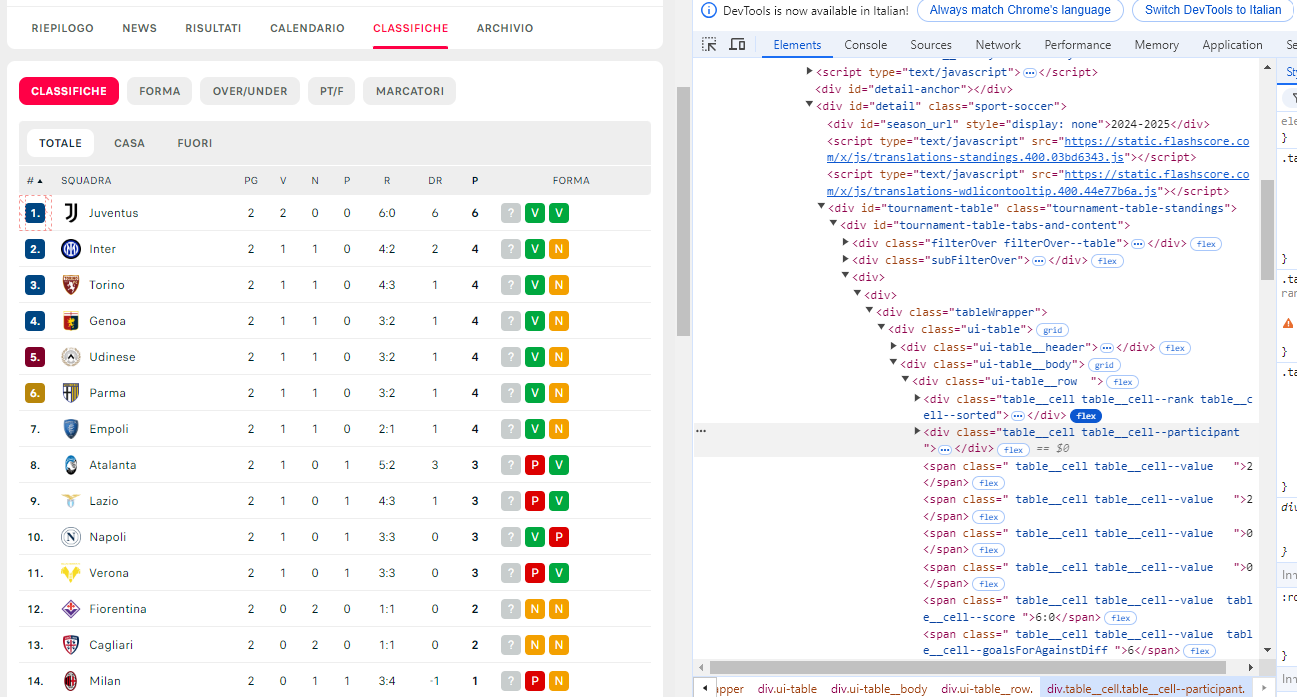

Web scraping scripts can fail if they try to interact with elements that have not fully loaded. Using `WebDriverWait` helps prevent such errors by ensuring elements are available before the script tries to interact with them.

This adds reliability and robustness to the web scraping or automated testing process by preventing scripts from breaking due to element loading delays.

In [14]:
# Open the webpage
driver.get(link_tournaments['Italy - Serie A'])

# Error Handling: wait until the table is loaded for a maximum of 10 seconds
WebDriverWait(driver, 10).until(
    EC.presence_of_element_located((By.CSS_SELECTOR, '.ui-table__body'))
)

# Find the table body
table_body = driver.find_element(By.CSS_SELECTOR, '.ui-table__body')

# Find all rows in the table body
rows = table_body.find_elements(By.CSS_SELECTOR, '.ui-table__row  ')

Examining the webpage's source code, we can observe that both the position number and the team name are enclosed within 'div' tags.

In [15]:
for i in range(len(rows[0].find_elements(By.TAG_NAME, 'div'))):
    print(rows[0].find_elements(By.TAG_NAME, 'div')[i].text)

1.
1.
Juventus
Juventus
Juventus
?
V
V
?
V
V


Instead, all the information about matches and goals is enclosed within 'span' tags.

In [16]:
for i in range(len(rows[0].find_elements(By.TAG_NAME, 'span'))):
    print(rows[0].find_elements(By.TAG_NAME, 'span')[i].text)

2
2
0
0
6:0
6
6
?
V
V


Thus, from the 'div' tags, we only need the first (or second) and third (or fourth or fifth) elements (which represent the rank and team name), whereas from the 'span' tags, we require all elements except the '?' string.


At the time of writing, there are only 2 recent matches recorded. The total number of columns related to the 'span' class is 13. Therefore, we have different scenarios:

* If there is only 1 last match, the actual number of colums is 9;
* If there are only 2 last matches, the actual number of colums is 10;
* If there are only 3 last matches, the actual number of colums is 11;
* If there are only 4 last matches, the actual number of colums is 12;
* If there are 5 last matches, the actual number of columns is 13;

If any teams have played fewer matches due to postponements, those entries will be recorded as NaN.

In [17]:
all_data = []

# Loop through each row and extract the data
for row in rows:
    # Extract text from specific elements within the current row
    divs=row.find_elements(By.TAG_NAME, 'div')
    spans=row.find_elements(By.TAG_NAME, 'span')
    row_data = {
        'Position': int(divs[1].text.split('.')[0]),
         'TeamName': divs[3].text,
         'Played': spans[0].text,
         'W': spans[1].text,
         'D': spans[2].text,
         'L': spans[3].text,
         'G scored': int(spans[4].text.split(':')[0]),
         'G conceded': int(spans[4].text.split(':')[1]),
         'GD': spans[5].text,
         'Points': spans[6].text,
    }
    
    # Extract Last Matches dynamically
    num_spans = len(row.find_elements(By.TAG_NAME, 'span'))
    
    for i in range(8, num_spans):
        row_data[f'LastMatch{i - 7}'] = row.find_elements(By.TAG_NAME, 'span')[i].text
    
    # Append the extracted row data to the list
    all_data.append(row_data)

#close the browser window and end the WebDriver session
driver.quit()

# Convert the list of dictionaries to a pandas DataFrame
df = pd.DataFrame(all_data)
df

,Position,TeamName,Played,W,D,L,G scored,G conceded,GD,Points,LastMatch1,LastMatch2
0,1,Juventus,2,2,0,0,6,0,6,6,V,V
1,2,Inter,2,1,1,0,4,2,2,4,V,N
2,3,Torino,2,1,1,0,4,3,1,4,V,N
3,4,Genoa,2,1,1,0,3,2,1,4,V,N
4,5,Udinese,2,1,1,0,3,2,1,4,V,N
5,6,Parma,2,1,1,0,3,2,1,4,V,N
6,7,Empoli,2,1,1,0,2,1,1,4,V,N
7,8,Atalanta,2,1,0,1,5,2,3,3,P,V
8,9,Lazio,2,1,0,1,4,3,1,3,P,V
9,10,Napoli,2,1,0,1,3,3,0,3,V,P


# Download

Store the dataframe as the `...\standings.csv` file

In [18]:
df.to_csv(os.getcwd()+os.sep+'standings.csv',index=False)